In [1]:
#from data.data import LoadData # import dataset
# import dionysus as d
import networkx as nx
from Graph_to_cellular.utils import convert_graph_dataset_with_rings
from torch_geometric.datasets import ZINC
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'graph_tool'

In [5]:
# dataset = LoadData('ZINC')
data = ZINC('datasets/ZINC',)

# train_loader = DataLoader(data[:1000], batch_size=32)
# val_loader = DataLoader(data[1000:1200], batch_size=32)
# test_loader = DataLoader(data[1200:1400], batch_size=32)


In [18]:
# Get the first graph in the dataset
data = data[0]

# Create a new NetworkX graph object
nx_graph = nx.Graph()

# Add the edges to the NetworkX graph
for i, j in zip(data.edge_index[0], data.edge_index[1]):
    nx_graph.add_edge(i.item(), j.item())

# Print the NetworkX graph
print(nx_graph)


Graph with 33 nodes and 36 edges


In [29]:
def get_simple_cycles(graph):
    digraph = graph.to_directed()
    cycles = [cycle for cycle in nx.simple_cycles(digraph)]
    return cycles
cycles = get_simple_cycles(nx_graph)
largest_cycle = max([len(cycle) for cycle in cycles])
cycles = [cycle for cycle in cycles if len(cycle) == largest_cycle]
print(cycles)

[[6, 32, 31, 30, 28, 11, 9, 8, 7], [6, 7, 8, 9, 11, 28, 30, 31, 32]]


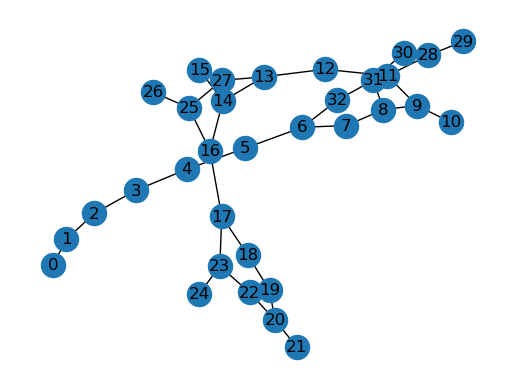

In [27]:
# draw the graph
pos = nx.spring_layout(nx_graph)  # layout algorithm
fig, ax = plt.subplots()  # create subplots and figure object
nx.draw(nx_graph, pos, with_labels=True, ax=ax)  # draw nodes and edges on subplot
plt.show()  # show the plot

In [31]:
def get_cycle_index(graph):
    digraph = nx.DiGraph(graph)
    cycles = list(nx.simple_cycles(digraph))
    cycle_index = {}
    node_set = set(graph.nodes())

    for i, cycle in enumerate(cycles):
        cycle_nodes = set(cycle)
        assert cycle_nodes <= node_set, "Cycle nodes not in graph"
        cycle_index[i] = [node for node in cycle]

    return cycle_index
idx = get_cycle_index(nx_graph)
print(idx)

{0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [4, 5], 5: [5, 6], 6: [6, 32, 31, 30, 28, 11, 9, 8, 7], 7: [6, 32, 31, 8, 7], 8: [6, 32], 9: [6, 7, 8, 31, 32], 10: [6, 7, 8, 9, 11, 28, 30, 31, 32], 11: [6, 7], 12: [7, 8], 13: [8, 31, 30, 28, 11, 9], 14: [8, 31], 15: [8, 9, 11, 28, 30, 31], 16: [8, 9], 17: [9, 11], 18: [9, 10], 19: [11, 28], 20: [11, 12], 21: [12, 13], 22: [13, 27, 25, 16, 14], 23: [13, 27], 24: [13, 14, 16, 25, 27], 25: [13, 14], 26: [14, 16], 27: [14, 15], 28: [16, 25], 29: [16, 17], 30: [25, 27], 31: [25, 26], 32: [17, 23, 22, 20, 19, 18], 33: [17, 23], 34: [17, 18, 19, 20, 22, 23], 35: [17, 18], 36: [18, 19], 37: [19, 20], 38: [20, 22], 39: [20, 21], 40: [24, 23], 41: [22, 23], 42: [32, 31], 43: [28, 30], 44: [28, 29], 45: [30, 31]}


In [42]:
import torch_geometric
from torch_geometric.transforms import *

In [43]:
class AddRandomWalkPE(BaseTransform):
    r"""Adds the random walk positional encoding from the `"Graph Neural
    Networks with Learnable Structural and Positional Representations"
    <https://arxiv.org/abs/2110.07875>`_ paper to the given graph
    (functional name: :obj:`add_random_walk_pe`).

    Args:
        walk_length (int): The number of random walk steps.
        attr_name (str, optional): The attribute name of the data object to add
            positional encodings to. If set to :obj:`None`, will be
            concatenated to :obj:`data.x`.
            (default: :obj:`"random_walk_pe"`)
    """
    def __init__(
        self,
        walk_length: int,
        attr_name: Optional[str] = 'random_walk_pe',
    ):
        self.walk_length = walk_length
        self.attr_name = attr_name

    def __call__(self, data: Data) -> Data:
        row, col = data.edge_index
        N = data.num_nodes

        value = data.edge_weight
        if value is None:
            value = torch.ones(data.num_edges, device=row.device)
        value = scatter(value, row, dim_size=N, reduce='sum').clamp(min=1)[row]
        value = 1.0 / value

        adj = to_torch_csr_tensor(data.edge_index, value, size=data.size())

        out = adj
        pe_list = [get_self_loop_attr(*to_edge_index(out), num_nodes=N)]
        for _ in range(self.walk_length - 1):
            out = out @ adj
            pe_list.append(get_self_loop_attr(*to_edge_index(out), N))
        pe = torch.stack(pe_list, dim=-1)

        data = add_node_attr(data, pe, attr_name=self.attr_name)
        return data

NameError: name 'BaseTransform' is not defined